In [19]:
import keras
import numpy as np
import pickle

In [20]:
from keras import layers
from keras import models
from keras import backend
from keras import optimizers
from sklearn.model_selection import train_test_split

In [21]:
with open('data/data.pkl', 'rb') as f:
    data = pickle.load(f)

x = data['x']
y = data['y']
print(x.shape)
print(y.shape)

(6454, 108, 128)
(6454, 9)


In [22]:
print(np.amax(x))
print(np.amin(x))

10.343756
-89.144424


In [23]:
#x = (x-np.amin(x))/(np.amax(x)-np.amin(x))

In [24]:
print(np.amax(x))
print(np.amin(x))

10.343756
-89.144424


In [25]:
(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2,
        random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


# How many songs by class
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

(5163, 108, 128)
(1291, 108, 128)
(5163, 9)
(1291, 9)
[859. 606. 570. 540. 547. 515. 515. 507. 504.]
[235. 163. 121. 132. 131. 133. 134. 119. 123.]


Model from deepsound.io

In [13]:
print('Building model...')

n_features = x_train.shape[2]
input_shape = (None, n_features)
model_input = layers.Input(input_shape, name='input')
layer = model_input
for i in range(3):
    # second convolutional layer names are used by extract_filters.py
    layer = layers.Convolution1D(
            filters=256,
            kernel_size=5,
            name='convolution_' + str(i + 1)
        )(layer)
    layer = layers.BatchNormalization(momentum=0.9)(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling1D(2)(layer)
    layer = layers.Dropout(0.5)(layer)

layer = layers.TimeDistributed(layers.Dense(9))(layer)
time_distributed_merge_layer = layers.Lambda(
        function=lambda x: backend.mean(x, axis=1),
        output_shape=lambda shape: (shape[0],) + shape[2:],
        name='output_merged'
    )
layer = time_distributed_merge_layer(layer)
layer = layers.Activation('softmax', name='output_realtime')(layer)
model_output = layer
model = models.Model(model_input, model_output)
opt = optimizers.Adam(lr=0.001)
model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )

print('Training...')
history = model.fit(
    x_train, y_train, batch_size=32, nb_epoch=100,
    validation_split=0.2, verbose=1, callbacks=[
        keras.callbacks.ModelCheckpoint(
            'models/model_salsa.h5', save_best_only=True, monitor='val_acc', verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
            verbose=1
        )
    ]
)

Building model...
Training...


C:\Users\bryan\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4130 samples, validate on 1033 samples
Epoch 1/100
4130/4130 [==============================] - 40s 10ms/step - loss: 2.3149 - acc: 0.1448 - val_loss: 2.2278 - val_acc: 0.1607

Epoch 00001: val_acc improved from -inf to 0.16070, saving model to models/model_salsa.h5
Epoch 2/100
4130/4130 [==============================] - 40s 10ms/step - loss: 2.2427 - acc: 0.1528 - val_loss: 2.2374 - val_acc: 0.0939

Epoch 00002: val_acc did not improve from 0.16070
Epoch 3/100
4130/4130 [==============================] - 40s 10ms/step - loss: 2.2264 - acc: 0.1584 - val_loss: 2.2205 - val_acc: 0.1578

Epoch 00003: val_acc did not improve from 0.16070
Epoch 4/100
4130/4130 [==============================] - 41s 10ms/step - loss: 2.2284 - acc: 0.1639 - val_loss: 2.2168 - val_acc: 0.1665

Epoch 00004: val_acc improved from 0.16070 to 0.16651, saving model to models/model_salsa.h5
Epoch 5/100
4130/4130 [==============================] - 41s 10ms/step - loss: 2.2271 - acc: 0.1668 - val_loss: 2.268

KeyboardInterrupt: 

Maximum validation accuracy in 100 epochs: 0.16651

In [38]:
model = models.Sequential()
model.add(layers.Convolution1D(256, 5, activation='relu',# padding='same',
                        input_shape=(None, x_train.shape[2])))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, activation='relu')) #, padding='same'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Convolution1D(256, 5, activation='relu')) #, padding='same'))
model.add(layers.MaxPooling1D(2))
model.add(layers.TimeDistributed(layers.Dense(9, activation='softmax')))
time_distributed_merge_layer = layers.Lambda(
            function=lambda x: backend.mean(x, axis=1),
            output_shape=lambda shape: (shape[0],) + shape[2:],
            name='output_merged'
        )
model.add(time_distributed_merge_layer)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 104, 256)          164096    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 100, 256)          327936    
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 50, 256)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 46, 256)           327936    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 42, 256)           327936    
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 21, 256)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 21, 9)             2313      
__________

In [36]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 4130 samples, validate on 1033 samples
Epoch 1/100
4130/4130 [==============================] - 35s 8ms/step - loss: 0.7987 - acc: 0.8605 - val_loss: 2.7399 - val_acc: 0.1200
Epoch 2/100
4130/4130 [==============================] - 35s 8ms/step - loss: 0.7208 - acc: 0.8862 - val_loss: 2.8587 - val_acc: 0.1404
Epoch 3/100
4130/4130 [==============================] - 35s 9ms/step - loss: 0.6609 - acc: 0.9039 - val_loss: 2.8853 - val_acc: 0.1365
Epoch 4/100
4130/4130 [==============================] - 36s 9ms/step - loss: 0.6010 - acc: 0.9245 - val_loss: 2.8411 - val_acc: 0.1123
Epoch 5/100
4130/4130 [==============================] - 36s 9ms/step - loss: 0.5500 - acc: 0.9387 - val_loss: 2.8380 - val_acc: 0.1210
Epoch 6/100
4130/4130 [==============================] - 36s 9ms/step - loss: 0.5329 - acc: 0.9324 - val_loss: 2.9758 - val_acc: 0.1481
Epoch 7/100
4130/4130 [==============================] - 36s 9ms/step - loss: 0.4984 - acc: 0.9363 - val_loss: 2.9540 - val_acc: 0.1133


4130/4130 [==============================] - 40s 10ms/step - loss: 0.0490 - acc: 0.9910 - val_loss: 4.0934 - val_acc: 0.1171
Epoch 61/100
4130/4130 [==============================] - 43s 10ms/step - loss: 0.0519 - acc: 0.9906 - val_loss: 4.0605 - val_acc: 0.1249
Epoch 62/100
4130/4130 [==============================] - 41s 10ms/step - loss: 0.0486 - acc: 0.9920 - val_loss: 4.0339 - val_acc: 0.1394
Epoch 63/100
4130/4130 [==============================] - 40s 10ms/step - loss: 0.0512 - acc: 0.9925 - val_loss: 4.1933 - val_acc: 0.1229
Epoch 64/100
4130/4130 [==============================] - 40s 10ms/step - loss: 0.0471 - acc: 0.9925 - val_loss: 4.1580 - val_acc: 0.1278
Epoch 65/100
4130/4130 [==============================] - 41s 10ms/step - loss: 0.0464 - acc: 0.9918 - val_loss: 4.2513 - val_acc: 0.1307
Epoch 66/100
4130/4130 [==============================] - 41s 10ms/step - loss: 0.0498 - acc: 0.9920 - val_loss: 4.1394 - val_acc: 0.1288
Epoch 67/100
4130/4130 [=======================

range(0, 100)


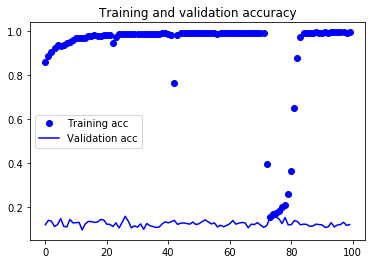

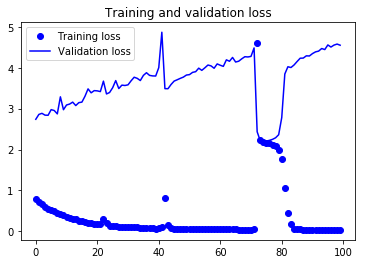

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [47]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [57]:
model = models.Sequential()
model.add(layers.Conv2D(149, (3, 3), activation='relu', #padding='same',
                        input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(layers.MaxPooling2D((2, 4)))#, padding='same'))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 5), activation='relu'))#, padding='same'))
model.add(layers.MaxPooling2D((2, 4)))#, padding='same'))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(9, activation = 'softmax'))

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 106, 126, 149)     1490      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 53, 31, 149)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 53, 31, 149)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 51, 27, 64)        143104    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 6, 64)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 6, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9600)              0         
__________

In [59]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

Train on 4130 samples, validate on 1033 samples
Epoch 1/100
4130/4130 [==============================] - 355s 86ms/step - loss: 2.2445 - acc: 0.1477 - val_loss: 2.1914 - val_acc: 0.1578
Epoch 2/100
4130/4130 [==============================] - 340s 82ms/step - loss: 2.1908 - acc: 0.1586 - val_loss: 2.1889 - val_acc: 0.1578
Epoch 3/100
4130/4130 [==============================] - 335s 81ms/step - loss: 2.1900 - acc: 0.1671 - val_loss: 2.1907 - val_acc: 0.1578
Epoch 4/100
4130/4130 [==============================] - 369s 89ms/step - loss: 2.1863 - acc: 0.1685 - val_loss: 2.1893 - val_acc: 0.1578
Epoch 5/100
4130/4130 [==============================] - 317s 77ms/step - loss: 2.1834 - acc: 0.1685 - val_loss: 2.1882 - val_acc: 0.1578
Epoch 6/100
4130/4130 [==============================] - 317s 77ms/step - loss: 2.1823 - acc: 0.1702 - val_loss: 2.1884 - val_acc: 0.1578
Epoch 7/100
4130/4130 [==============================] - 307s 74ms/step - loss: 2.1798 - acc: 0.1695 - val_loss: 2.1910 - va

KeyboardInterrupt: 

range(0, 20)


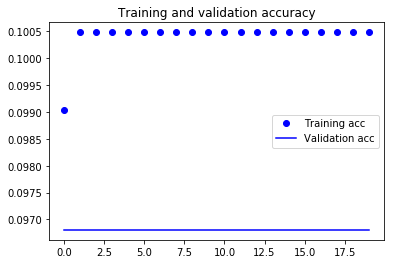

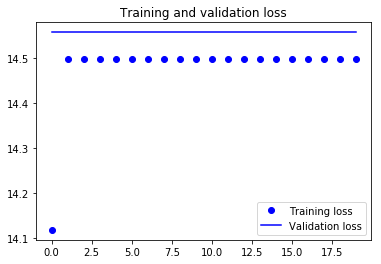

In [43]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()